# Homework 1: Machine Learning Assignment



## Question 1

In [7]:
import os
# Create figures directory if it doesn't exist
if not os.path.exists('figures'):
    os.makedirs('figures')
    print("Created figures/ directory")
else:
    print("figures/ directory already exists")

figures/ directory already exists


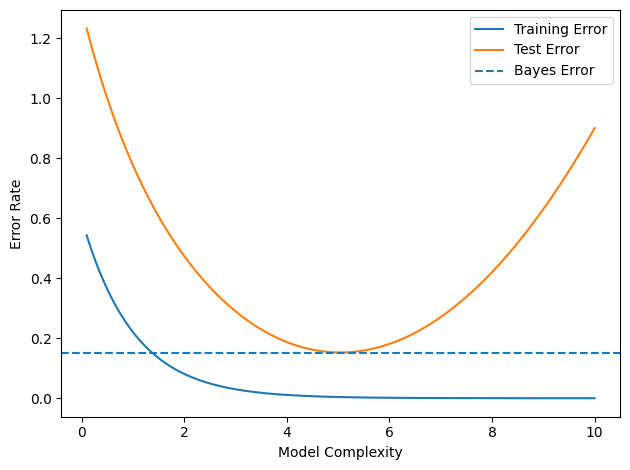

In [8]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0.1, 10, 200)
bayes = 0.15

train_err = 0.6*np.exp(-x)
test_err = 0.4*np.exp(-x) + 0.03*(x-5)**2 + bayes

plt.figure()
plt.plot(x, train_err, label="Training Error")
plt.plot(x, test_err, label="Test Error")
plt.axhline(bayes, linestyle="--", label="Bayes Error")
plt.xlabel("Model Complexity")
plt.ylabel("Error Rate")
plt.legend()
plt.tight_layout()
plt.savefig("figures/complexity_curve.png")
plt.show()



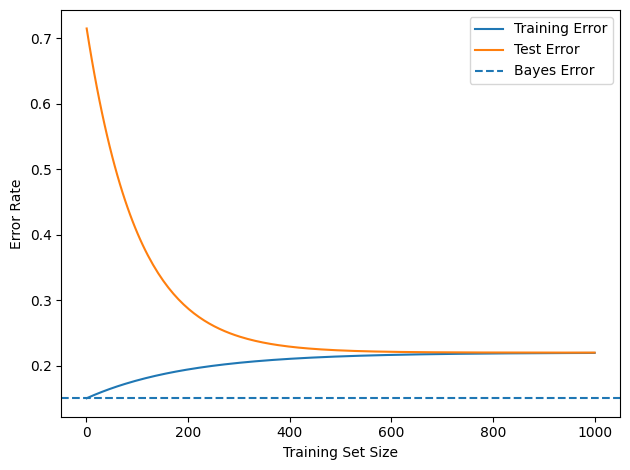

In [9]:
n = np.linspace(1, 1000, 200)
bayes = 0.15
plateau = 0.22

train_err = bayes + (plateau-bayes)*(1-np.exp(-n/200))
test_err = plateau + 0.5*np.exp(-n/100)

plt.figure()
plt.plot(n, train_err, label="Training Error")
plt.plot(n, test_err, label="Test Error")
plt.axhline(bayes, linestyle="--", label="Bayes Error")
plt.xlabel("Training Set Size")
plt.ylabel("Error Rate")
plt.legend()
plt.tight_layout()
plt.savefig("figures/datasize_curve.png")
plt.show()


## Question 4
This notebook implements all required tasks for:
- Task A: Data Loading
- Task B: Decision Tree Model Selection
- Task C: Decision Tree Visualization
- Task D: Manual Information Gain Calculation
- Task E: KNN Model Selection with Plotting

In [10]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import plot_tree, export_text
import matplotlib.pyplot as plt
from collections import Counter
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## Task A: Data Loading

In [11]:
def load_data(exists_path='h1_data/exists_climate.csv', dne_path='h1_data/DNE_climate.csv'):
    """
    Loads climate data from two CSV files, processes text using CountVectorizer,
    and splits into train/validation/test sets.
    
    Parameters:
    -----------
    exists_path : str
        Path to exists_climate.csv file
    dne_path : str
        Path to DNE_climate.csv file
    
    Returns:
    --------
    X_train, X_val, X_test : sparse matrices
        Feature matrices for training, validation, and test sets
    y_train, y_val, y_test : arrays
        Target labels for training, validation, and test sets
    vectorizer : CountVectorizer
        Fitted vectorizer object for transforming new data
    """
    # Load the CSV files
    exists_df = pd.read_csv(exists_path)
    dne_df = pd.read_csv(dne_path)
    
    # Create labels: 'exists' as class 1, 'DNE' as class 0
    exists_df['label'] = 1
    dne_df['label'] = 0
    
    # Combine the datasets
    combined_df = pd.concat([exists_df, dne_df], ignore_index=True)
    
    # Extract text and labels
    texts = combined_df['tweet'].values
    labels = combined_df['label'].values
    
    # Initialize CountVectorizer with English stop words
    vectorizer = CountVectorizer(stop_words='english')
    
    # Transform text to feature matrix
    X = vectorizer.fit_transform(texts)
    
    # Split data: 70% train, 15% validation, 15% test
    # First split: 70% train, 30% temp (which will be split into val and test)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, labels, test_size=0.15, random_state=42, stratify=labels
    )
    
    # Second split: 70% train, 15% validation (from the 85% remaining)
    # We need 15% of total = 15/85 of temp = ~17.65% of temp
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.15/0.85, random_state=42, stratify=y_temp
    )
    
    print(f"Training set size: {X_train.shape[0]}")
    print(f"Validation set size: {X_val.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")
    print(f"Feature dimension: {X_train.shape[1]}")
    print(f"Class distribution - Train: {np.bincount(y_train)}")
    print(f"Class distribution - Val: {np.bincount(y_val)}")
    print(f"Class distribution - Test: {np.bincount(y_test)}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, vectorizer

# Load the data
X_train, X_val, X_test, y_train, y_val, y_test, vectorizer = load_data()

Training set size: 2930
Validation set size: 628
Test set size: 629
Feature dimension: 10101
Class distribution - Train: [ 769 2161]
Class distribution - Val: [165 463]
Class distribution - Test: [165 464]


## Task B: Decision Tree Model Selection

In [12]:
def select_tree_model(X_train, y_train, X_val, y_val):
    """
    Performs a grid search over decision tree hyperparameters.
    
    Parameters:
    -----------
    X_train : sparse matrix
        Training feature matrix
    y_train : array
        Training labels
    X_val : sparse matrix
        Validation feature matrix
    y_val : array
        Validation labels
    
    Returns:
    --------
    best_params : dict
        Best hyperparameters found
    best_accuracy : float
        Best validation accuracy
    results : list
        List of all (params, accuracy) tuples
    """
    max_depths = [2, 5, 10, 20, None]
    criteria = ['gini', 'entropy']
    
    results = []
    best_accuracy = 0
    best_params = None
    
    print("Decision Tree Hyperparameter Sweep:")
    print("=" * 60)
    
    for max_depth in max_depths:
        for criterion in criteria:
            # Train DecisionTreeClassifier
            clf = DecisionTreeClassifier(max_depth=max_depth, criterion=criterion, random_state=42)
            clf.fit(X_train, y_train)
            
            # Evaluate on validation set
            val_accuracy = clf.score(X_val, y_val)
            
            # Store results
            params = {'max_depth': max_depth, 'criterion': criterion}
            results.append((params, val_accuracy))
            
            # Print results
            depth_str = str(max_depth) if max_depth is not None else "None"
            print(f"max_depth={depth_str:4s}, criterion={criterion:8s} -> Validation Accuracy: {val_accuracy:.4f}")
            
            # Track best model
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_params = params
    
    print("=" * 60)
    print(f"Best parameters: {best_params}")
    print(f"Best validation accuracy: {best_accuracy:.4f}")
    
    return best_params, best_accuracy, results

# Run the decision tree sweep
best_tree_params, best_tree_acc, tree_results = select_tree_model(X_train, y_train, X_val, y_val)

Decision Tree Hyperparameter Sweep:
max_depth=2   , criterion=gini     -> Validation Accuracy: 0.7564
max_depth=2   , criterion=entropy  -> Validation Accuracy: 0.7564
max_depth=5   , criterion=gini     -> Validation Accuracy: 0.7707
max_depth=5   , criterion=entropy  -> Validation Accuracy: 0.7723
max_depth=10  , criterion=gini     -> Validation Accuracy: 0.7930
max_depth=10  , criterion=entropy  -> Validation Accuracy: 0.7739
max_depth=20  , criterion=gini     -> Validation Accuracy: 0.7882
max_depth=20  , criterion=entropy  -> Validation Accuracy: 0.7850
max_depth=None, criterion=gini     -> Validation Accuracy: 0.8121
max_depth=None, criterion=entropy  -> Validation Accuracy: 0.7930
Best parameters: {'max_depth': None, 'criterion': 'gini'}
Best validation accuracy: 0.8121


## Task C: Decision Tree Visualization

In [13]:
# Retrain the best model from Task B
best_tree = DecisionTreeClassifier(
    max_depth=best_tree_params['max_depth'],
    criterion=best_tree_params['criterion'],
    random_state=42
)
best_tree.fit(X_train, y_train)

print(f"Retrained best model with parameters: {best_tree_params}")
print(f"Validation accuracy: {best_tree.score(X_val, y_val):.4f}")
print(f"Test accuracy: {best_tree.score(X_test, y_test):.4f}")

Retrained best model with parameters: {'max_depth': None, 'criterion': 'gini'}
Validation accuracy: 0.8121
Test accuracy: 0.8172


In [14]:
# Visualize the first 2 layers using plot_tree
plt.figure(figsize=(20, 10))
plot_tree(best_tree, max_depth=2, filled=True, feature_names=vectorizer.get_feature_names_out(), 
          class_names=['DNE', 'Exists'], fontsize=10)
plt.title('Decision Tree - First 2 Layers', fontsize=16)
plt.savefig('figures/q4_tree_viz.png', dpi=300, bbox_inches='tight')
plt.close()
print("Saved decision tree visualization to figures/q4_tree_viz.png")

Saved decision tree visualization to figures/q4_tree_viz.png


In [15]:
# Alternative visualization using export_text (first 2 layers)
tree_text = export_text(best_tree, max_depth=2, feature_names=vectorizer.get_feature_names_out())
print("Decision Tree Structure (First 2 Layers):")
print("=" * 80)
print(tree_text)

Decision Tree Structure (First 2 Layers):
|--- warming <= 0.50
|   |--- tcot <= 0.50
|   |   |--- utah <= 0.50
|   |   |   |--- truncated branch of depth 96
|   |   |--- utah >  0.50
|   |   |   |--- class: 0
|   |--- tcot >  0.50
|   |   |--- rt <= 0.50
|   |   |   |--- truncated branch of depth 9
|   |   |--- rt >  0.50
|   |   |   |--- class: 0
|--- warming >  0.50
|   |--- gore <= 0.50
|   |   |--- scam <= 0.50
|   |   |   |--- truncated branch of depth 161
|   |   |--- scam >  0.50
|   |   |   |--- class: 0
|   |--- gore >  0.50
|   |   |--- bashing <= 0.50
|   |   |   |--- truncated branch of depth 9
|   |   |--- bashing >  0.50
|   |   |   |--- truncated branch of depth 2



## Task D: Manual Information Gain Calculation

In [16]:
def entropy(y):
    """
    Calculate entropy H(Y) manually.
    
    Parameters:
    -----------
    y : array-like
        Target labels
    
    Returns:
    --------
    float : Entropy value
    """
    if len(y) == 0:
        return 0
    
    # Count occurrences of each class
    counts = Counter(y)
    total = len(y)
    
    # Calculate entropy: H(Y) = -sum(p(y) * log2(p(y)))
    entropy_val = 0
    for count in counts.values():
        p = count / total
        if p > 0:  # Avoid log(0)
            entropy_val -= p * np.log2(p)
    
    return entropy_val


def compute_information_gain(data, feature_name, target_name):
    """
    Manually compute information gain for a binary feature split.
    
    Information Gain = H(Y) - H(Y|feature)
    where H(Y) is the entropy of the target
    and H(Y|feature) is the conditional entropy given the feature
    
    Parameters:
    -----------
    data : DataFrame
        Dataset with features and target
    feature_name : str
        Name of the feature column (binary: 0 or 1)
    target_name : str
        Name of the target column
    
    Returns:
    --------
    float : Information gain value
    """
    # Extract target values
    y = data[target_name].values
    
    # Calculate H(Y) - entropy of target
    H_Y = entropy(y)
    
    # Calculate H(Y|feature) - conditional entropy
    # Split data based on feature value (0 or 1)
    feature_values = data[feature_name].values
    
    # Get indices where feature is present (1) and absent (0)
    present_indices = feature_values == 1
    absent_indices = feature_values == 0
    
    y_present = y[present_indices]
    y_absent = y[absent_indices]
    
    # Calculate conditional entropy: H(Y|feature) = p(feature=0)*H(Y|feature=0) + p(feature=1)*H(Y|feature=1)
    n_total = len(y)
    n_present = len(y_present)
    n_absent = len(y_absent)
    
    # Handle edge cases
    if n_total == 0:
        return 0
    
    p_present = n_present / n_total
    p_absent = n_absent / n_total
    
    H_Y_given_present = entropy(y_present) if n_present > 0 else 0
    H_Y_given_absent = entropy(y_absent) if n_absent > 0 else 0
    
    H_Y_given_feature = p_present * H_Y_given_present + p_absent * H_Y_given_absent
    
    # Information Gain = H(Y) - H(Y|feature)
    information_gain = H_Y - H_Y_given_feature
    
    return information_gain

In [17]:
# Example: Compute information gain for a few features
# Convert sparse matrix to dense for easier manipulation
X_train_dense = X_train.toarray()
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame for easier computation
train_df = pd.DataFrame(X_train_dense, columns=feature_names)
train_df['target'] = y_train

# Compute information gain for top 10 most frequent features
feature_counts = X_train.sum(axis=0).A1  # Sum across rows, convert to 1D array
top_features_idx = np.argsort(feature_counts)[-10:][::-1]  # Top 10 features

print("Information Gain for Top 10 Most Frequent Features:")
print("=" * 80)
for idx in top_features_idx:
    feature_name = feature_names[idx]
    ig = compute_information_gain(train_df, feature_name, 'target')
    print(f"Feature: {feature_name:20s} | Information Gain: {ig:.6f}")

Information Gain for Top 10 Most Frequent Features:
Feature: http                 | Information Gain: 0.015375
Feature: global               | Information Gain: 0.092796
Feature: warming              | Information Gain: 0.091983
Feature: climate              | Information Gain: 0.071898
Feature: change               | Information Gain: 0.063709
Feature: bitly                | Information Gain: 0.006933
Feature: rt                   | Information Gain: 0.016528
Feature: snow                 | Information Gain: 0.014682
Feature: new                  | Information Gain: 0.001755
Feature: retwtme              | Information Gain: 0.005028


## Task E: KNN Model Selection with Plotting

In [18]:
def select_knn_model(X_train, y_train, X_val, y_val, k_range=range(1, 21)):
    """
    Performs a sweep over k values for KNN and plots training vs validation error.
    
    Parameters:
    -----------
    X_train : sparse matrix
        Training feature matrix
    y_train : array
        Training labels
    X_val : sparse matrix
        Validation feature matrix
    y_val : array
        Validation labels
    k_range : range
        Range of k values to test (default: 1 to 20)
    
    Returns:
    --------
    best_k : int
        Best k value found
    train_errors : list
        Training errors for each k
    val_errors : list
        Validation errors for each k
    """
    train_errors = []
    val_errors = []
    k_values = list(k_range)
    
    print("KNN Hyperparameter Sweep:")
    print("=" * 60)
    
    for k in k_values:
        # Train KNeighborsClassifier
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        # Calculate errors (1 - accuracy)
        train_error = 1 - knn.score(X_train, y_train)
        val_error = 1 - knn.score(X_val, y_val)
        
        train_errors.append(train_error)
        val_errors.append(val_error)
        
        print(f"k={k:2d} -> Training Error: {train_error:.4f}, Validation Error: {val_error:.4f}")
    
    # Find best k (lowest validation error)
    best_k_idx = np.argmin(val_errors)
    best_k = k_values[best_k_idx]
    
    print("=" * 60)
    print(f"Best k: {best_k}")
    print(f"Best validation error: {val_errors[best_k_idx]:.4f}")
    
    return best_k, train_errors, val_errors

# Run the KNN sweep
best_k, train_errors, val_errors = select_knn_model(X_train, y_train, X_val, y_val)

KNN Hyperparameter Sweep:
k= 1 -> Training Error: 0.0055, Validation Error: 0.2022
k= 2 -> Training Error: 0.1229, Validation Error: 0.2866
k= 3 -> Training Error: 0.0792, Validation Error: 0.2277
k= 4 -> Training Error: 0.1884, Validation Error: 0.2755
k= 5 -> Training Error: 0.1341, Validation Error: 0.2293
k= 6 -> Training Error: 0.1853, Validation Error: 0.2659
k= 7 -> Training Error: 0.1287, Validation Error: 0.1943
k= 8 -> Training Error: 0.1608, Validation Error: 0.2197
k= 9 -> Training Error: 0.1560, Validation Error: 0.2197
k=10 -> Training Error: 0.1700, Validation Error: 0.2309
k=11 -> Training Error: 0.1809, Validation Error: 0.2213
k=12 -> Training Error: 0.1843, Validation Error: 0.2229
k=13 -> Training Error: 0.1997, Validation Error: 0.2357
k=14 -> Training Error: 0.2027, Validation Error: 0.2373
k=15 -> Training Error: 0.2065, Validation Error: 0.2357
k=16 -> Training Error: 0.2055, Validation Error: 0.2357
k=17 -> Training Error: 0.2126, Validation Error: 0.2325
k=18 

In [19]:
# Plot Training vs Validation Error (similar to ESL Fig 2.4)
plt.figure(figsize=(10, 6))
k_values = list(range(1, 21))
plt.plot(k_values, train_errors, 'o-', label='Training Error', linewidth=2, markersize=8)
plt.plot(k_values, val_errors, 's-', label='Validation Error', linewidth=2, markersize=8)
plt.xlabel('k (Number of Neighbors)', fontsize=12)
plt.ylabel('Error Rate', fontsize=12)
plt.title('KNN: Training vs Validation Error', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(k_values)
plt.tight_layout()
plt.savefig('figures/q4_knn_error.png', dpi=300, bbox_inches='tight')
plt.close()
print("Saved KNN error plot to figures/q4_knn_error.png")

# Print summary
print(f"\nSummary:")
print(f"Best k: {best_k}")
print(f"Training error at best k: {train_errors[best_k-1]:.4f}")
print(f"Validation error at best k: {val_errors[best_k-1]:.4f}")

Saved KNN error plot to figures/q4_knn_error.png

Summary:
Best k: 7
Training error at best k: 0.1287
Validation error at best k: 0.1943


In [20]:
# Evaluate best KNN model on test set
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)
test_accuracy = best_knn.score(X_test, y_test)
print(f"Best KNN (k={best_k}) Test Accuracy: {test_accuracy:.4f}")

Best KNN (k=7) Test Accuracy: 0.7806
